[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1y_VpfrOomKm33b6BxlmeNj09JEbV1b2a?usp=sharing)

# Machine Learning for Natural Language Processing Project
By: Georges SARR, Hamdi BEL HADJ HASSINE

In [1]:
! git clone https://github.com/geosarr/search-engine

Cloning into 'search-engine'...
remote: Enumerating objects: 300, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 300 (delta 17), reused 14 (delta 8), pack-reused 263
Receiving objects: 100% (300/300), 3.84 MiB | 16.46 MiB/s, done.
Resolving deltas: 100% (165/165), done.


In [2]:
! pip install datasets
! pip install gensim --upgrade
! pip install nltk
! pip install tqdm
! pip install transformers

     |████████████████████████████████| 325 kB 5.0 MB/s 
     |████████████████████████████████| 77 kB 5.7 MB/s 
     |████████████████████████████████| 212 kB 43.9 MB/s 
     |████████████████████████████████| 136 kB 43.1 MB/s 
     |████████████████████████████████| 1.1 MB 49.8 MB/s 
     |████████████████████████████████| 127 kB 59.4 MB/s 
     |████████████████████████████████| 144 kB 56.2 MB/s 
     |████████████████████████████████| 271 kB 57.6 MB/s 
     |████████████████████████████████| 94 kB 3.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 24.1 MB 79.4 MB/s

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

import sys
sys.path.insert(0, "./search-engine")

from model_utils import tf, idf, unigram, doc_embed, cluster_docs, wd, opt_svd 
from search_models import Boolean, Vsm, Bim, BimExt, QueryLklhd, W2Vsm, Lsi
from search import searching 
from saveload import indexing
from indices import SubInvertedIndex
from evaluation import MRR,MAP, run_benchmark

import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import pandas as pd

import gensim
import gensim.downloader as api

from tqdm.auto import tqdm
import datasets
import torch
from torch.optim import Adam
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import get_scheduler
from torch.utils.data import DataLoader
from datasets import load_dataset
import joblib
from collections import Counter
from sklearn.metrics import confusion_matrix, roc_curve, auc, plot_roc_curve
import matplotlib.pyplot as plt
import seaborn as sn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Indexing the documents collection

In [2]:
judgments=dict()
inverted_index_sortpost, judgments=indexing(dataset="ms_marco", save=True, save_load_path="./data", index_type='inv', judgments=judgments, version="v1.1", split="test")

.....................Collection indexation in progress.....................


Reusing dataset ms_marco (/root/.cache/huggingface/datasets/ms_marco/v1.1/1.1.0/b6a62715fa5219aea5275dd3556601004cd63945cb63e36e022f77bb3cbbca84)
100%|██████████| 9650/9650 [00:47<00:00, 201.40it/s]

.....................Failed to save the index.....................


# Statistics

In [ ]:
print(f"The vocabulary is made of {len(inverted_index_sortpost.index)} words")

The vocabulary is made of 132161 words


### Document lengths


There are 79176 documents


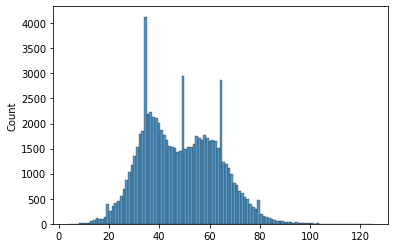

In [ ]:
print(f"There are {len(inverted_index_sortpost.documents)} documents")
doc_lenghts=[len(inverted_index_sortpost.raw_freq[ID]) for ID in inverted_index_sortpost.documents]
sb.histplot(doc_lenghts)

In [ ]:
round(pd.DataFrame({"doc_lengths": doc_lenghts}).describe(),0)

,doc_lengths
count,79176.0
mean,49.0
std,15.0
min,4.0
25%,37.0
50%,48.0
75%,60.0
max,125.0


### Word raw frequencies

In [ ]:
# average number of time each token appears in a document
avg_raw_freqs = [np.mean([inverted_index_sortpost.raw_freq[ID][term] for ID in inverted_index_sortpost.index[term]]) for term in inverted_index_sortpost.index]
round(pd.DataFrame({"avg_raw_freqs":avg_raw_freqs}).describe(),0)

,avg_raw_freqs
count,132161.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,24.0


Most of the terms appear just once in a document.

### Document frequencies

In [ ]:
doc_freqs=[len(inverted_index_sortpost.index[token]) for token in inverted_index_sortpost.index]
round(pd.DataFrame({"doc_freqs": doc_freqs}).describe(),0)

,doc_freqs
count,132161.0
mean,29.0
std,571.0
min,1.0
25%,1.0
50%,2.0
75%,5.0
max,73633.0


A term appears on average in 30 $\pm$ 500 documents, 75% of the terms appear in less than 5 documents (a lot of rare terms, weird ??). Lets try to visualize why.

In [ ]:
for pos , term in enumerate(inverted_index_sortpost.index) : 
    if pos<=500 and len(inverted_index_sortpost.index[term])<=5: print(term) 

stink
relocate
scatter
deters
npr
contributory
fuelsoil
coaltake
circumscribes
apothems
4cm
polygonsproperties
incircle
congruent
equilateral
sagitta
inradius
mathworld
weisstein
hypotenuse


It looks plausible when we look at the above sequence of words (they look rare indeed)


### Relevance judgments

Judgments are used to evaluate models, each query is associated to some relevant documents, and those documents have a relevance score 


In [ ]:
[f'{query}: {judgments[query]}' for pos, query in enumerate(judgments) if pos<=2]

['does human hair stop squirrels: {1: 1, 2: 1, 3: 2, 4: 1, 5: 1, 6: 1, 7: 1}',
 'what are the benefits of fossil fuels: {8: 1, 9: 2, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1}',
 'what is a apothem: {17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 2, 23: 1, 24: 1, 25: 1}']

In [ ]:
round(pd.DataFrame({"nb_judgments":[len(judgments[query]) for query in judgments]}).describe(),0)

,nb_judgments
count,9650.0
mean,8.0
std,1.0
min,2.0
25%,7.0
50%,9.0
75%,9.0
max,11.0


On average 8 judgment(s) per query

In [ ]:
print(f"The minimum and maximum relevance scores are {min([min(judgments[query].values()) for query in judgments])} and {max([max(judgments[query].values()) for query in judgments])} respectively")

The minimum and maximum relevance scores are 1 and 2 respectively


# Preparing for search

### TF-IDF and language model


By default, the **term frequency** TF(t,d) of a term $t$ in document $d$ is given by
$$
TF(t,d)= 1+\log_{10}(n_{t,d})
$$
where $n_{t,d}$ is the raw frequency (the number of occurences) of term $t$ in document $d$, and the **inverse document frequency** of $t$ is given by:
$$
IDF(t) = \log_{10}\bigg(\frac{|C|}{\big|\{d \in C, t\in d\}\big|}\bigg)
$$
where $C$ is the set of documents in the collection, and $|E|$ designates the cardinal of set $E$. Other variations of formula are also implemented. 

TF-IDFs are used to represent documents/queries in a same vector space (it is the Vector Space Model (Vsm)), coordinates being the TF-IDFs. This representation is sparse because documents/queries do not generally include most of the words in the collection). In Vsm, cosine similarity between query vector and document vectors is used to rank documents.


The language model used is the **unigram model** where each term appearing in the documents are modelled as random instances with probability distribution given by:
$$
\mathbb{P}(t|d) = \frac{n_{t,d}}{n_d}
$$
where $n_{t,d}$ is the total number of occurences (raw frequency) of $t$ in document $d$, and $n_d$ is the total of occurrences of all terms appearing in the document (i.e the sum of the $n_{t',d}$ s). The language model is used to compute the query likelihood model (QueryLklhd) in which the aim is to estimate the probability $\mathbb{P}(q|d)$ of query $q$ given document $d$ and rank the documents in a decreasing order of the estimates. If $q="t_1 t_2 ... t_q"$ then

In the original version of query likelihood model, it is assumed 
$$\mathbb{P}(q|d) = \prod_{j=1}^q\mathbb{P}(t_j|d)$$

This formulation allows $\mathbb{P}(q|d)=0$ if there exists a term appearing in the query and not in the document. To avoid this, some extensions of the query likelihood model suggest a smoothing scheme (Laplace smoothing , Jelinek smoothing for example). These smoothings are not implemented yet, :). Instead the current implementation assumes $$\mathbb{P}(q|d) = \prod_{j=1 , t_j\in d}^q\mathbb{P}(t_j|d)$$

In [ ]:
tfreqs, idfs, unigram_model=tf(inverted_index_sortpost), idf(inverted_index_sortpost), unigram(inverted_index_sortpost)


100%|██████████| 79176/79176 [00:05<00:00, 14451.46it/s]


### Uploading word2vec model

google news word2vec model is used, It takes roughly up to 10 minutes to download, Run it ONCE per session.

In [ ]:
## Takes up to 10 minutes to run, but TO RUN ONCE !!!
path = api.load("word2vec-google-news-300", return_path=True)
# path="/root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz"

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
# Takes up to 1 minute to load the google news word2vec model
w2v = gensim.models.KeyedVectors.load_word2vec_format(path, binary=True)

In [ ]:
print(f"Word2Vec model vocabulary size = {len(w2v.key_to_index)} words")

Word2Vec model vocabulary size = 3000000 words


### Document embedding


Once we have the embeddings of the terms in the collection, one can compute the document embeddings by taking a weighted average of the embeddings of the terms it contains, that is the a document's embedding is given by:

$$
d_{embed} =  \sum_{t \in d} \frac{w_{t,d}}{\sum_{t'\in d} w_{t',d}}  t_{embed}
$$
where $w_{t,d}$ is a weight for term $t\in d$, $w_{t,d}=TF(t,d)\times IDF(t)$ is used in the current implementation

In [ ]:
doc2vec=doc_embed(inverted_index_sortpost, tfreqs, idfs, w2v)

100%|██████████| 79176/79176 [01:17<00:00, 1021.40it/s]


 ### Document clustering

Once documents have a numerical vector-like representation, one can cluster them. Why clustering ? The main reason is to speed-up retrieval (see W2Vec vector space model illustration). In fact when the representation of vectors is dense, computing cosine similarities on a large collection may take time. To speed up retrieval, one can precluster the documents first before a query is issued. When a query comes in, the query vector is compared to the centers (or representer in general) of the clusters (so a relatively small number of cosine similarities to compute), and afterwards the query is compared by cosine similarity to the documents in the clusters whose centers/representers are the most similar to the query.  

Penalised inertia is used to compute the optimal Kmeans model with repect to the number of clusters. The objective is to minimise:

$$
\text{Penalised Inertia}(K) = \text{Inertia}(K) - \text{penalty}\times K
$$
w.r.t $K$

Computing K-means model for different values of K


100%|██████████| 4/4 [33:52<00:00, 508.20s/it]


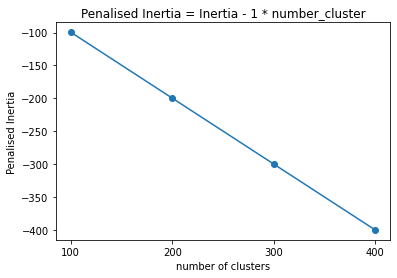

In [ ]:
doc_kmeans=cluster_docs(inverted_index_sortpost, doc_embeds=doc2vec,num_min_centr=100,num_max_centr=500, penalty=1, step=100, plot=True)


### Singular Value Decomposition of a word-document occurrence matrix

This is used for latent semantic indexing, a model used in order to capture some semantic relation between the query and the documents in the collection. The idea behind this model is to start from a matrix whose coefficients are the raw frequencies of the terms in documents: 
$$
WD=(n_{t,d}) \in \mathbb{R}^{|T|\times |C|}
$$
where $T$ is the set of all the terms in the collection $C$.

An SVD decomposition of $WD$ is given by:
$$
WD = U S V
$$

where $U\in \mathbb{O}(|T|)$ and $V \in \mathbb{O}(|C|)$ are orthogonal matrices and $S\in \mathbb{R}^{|T|\times |C|}$ is a generalized diagonal matrix (all $S_{i,j}=0$ for $i\neq j$). $U$ represents the matrix of latent vectors expressed in the term space and $SV$ is the matrix of the document vectors expressed in the latent space
$$
\text{terms} \left\{
    \begin{array}{ll}
         &  \\
        & 
    \end{array}
\right. \overbrace{\begin{pmatrix}
 & & & \\
 & & & \\
 \end{pmatrix}}^{\text{latent vectors}}=U
$$

$$
\text{latent vectors} \left\{
    \begin{array}{ll}
         &  \\
        & 
    \end{array}
\right. \overbrace{\begin{pmatrix}
 & & & \\
 & & & \\
 \end{pmatrix}}^{\text{document vectors}}=SV
$$

To rank the documents, one projects the query vector on the latent space and compare the result to the documents representation in the latent space by cosine similarity (i.e computing $\cos(U'q, (SV)_i)$), $U'$ designates the transpose of $U$.

However from a practical point of view, $WD$ is very big in memory if we consider the whole collection (more than 10 billion integers to store in memory, easily more than 200 GB), that is why a random selection of documents is conducted first and $WD$ is built from those selected documents. 

In [ ]:
sub_inv = SubInvertedIndex()
nb_docs=len(inverted_index_sortpost.documents)
nb_sampled_docs=1000
sampled_docs=np.random.choice(a=range(1,nb_docs+1),size=nb_sampled_docs, replace=False)
sub_inv.reindex(inverted_index_sortpost, sampled_docs)

100%|██████████| 1000/1000 [00:00<00:00, 315527.27it/s]


In [ ]:
WD, wtoi, dtoi = wd(sub_inv)
WD.shape

1000it [00:00, 14419.36it/s]


(11808, 1000)

To speed up the retrieval a little bit, one chooses the K largest singular values of $WD$ instead and project the query vector on the space engendered by the corresponding latent vectors, not computing $\cos(U'q, (SV)_i)$ but computing $\cos(U_K'q, (S_KV_K)_i)$ to rank the documents, where $U_K \in \mathbb{R}^{|T|\times K}$, $S_K \in \mathbb{R}^{K\times K}$, $V_K \in \mathbb{R}^{K\times |C|}$.

The optimal $K$ is computed by maximizing with respect to $K$

$$
PSSV(K) = \sum_{k=1}^K \sigma_k - \text{penalty}\times K
$$

where $\sigma_k$ is the $k^{th}$ largest singular value of $WD$

Computing SVDs for different values of k


100%|██████████| 5/5 [03:13<00:00, 38.67s/it]


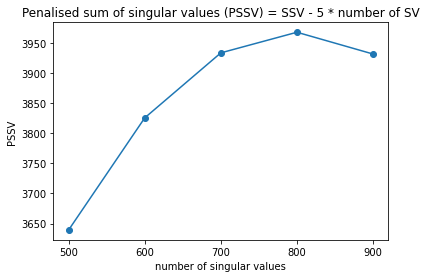

In [ ]:
svd_mats=opt_svd(WD,min_k=500,max_k=1000,step_k=100, penalty=5,plot=True)

# Searching


### Simple boolean retrieval


In [ ]:
bl=Boolean(index=inverted_index_sortpost, query_type="AND", correct_query=True)
searching(bl)

Welcome to the best search engine ever :)
Enter some keywords or type "exit" to stop the engine: where is France ?
Did you mean: where is trance ?


Your query:  where is France ?

Result(s): 
Nearly three times as much grenache is planted in Spain as in France. The spanish know this grape and wine as garnacha or garnacha tinta, where it is the dominant red wine variety in Catalonia and prominent in Rioja. 2 The grape is known in Italy as cannonau. Prior to the establishment of France's AOC, Burgundy's dirty little secret was that Grenache, grown in the Rhone Rhône, valley often contributed flavorful appeal to save the sometimes thin and Weak Pinot. Noir on its, own grenache can make, fleshy heady wines with lots of fruit appeal in their. youth 

Grenache (/ɡrəˈnɑːʃ/) or Garnacha (. [ɡarˈnatʃa]) is one of the most widely planted red wine grape varieties in the world. It ripens late, so it needs hot, dry conditions such as those found in Spain, where the grape most likely originated. It

The correction is not good enough :). The retrieved documents, if any, are all judged relevant by the model according to the specified `query_type` argument. But in practice models with relevance score are preferred

### Vector Space Model

In [ ]:
vsm=Vsm(index=inverted_index_sortpost, tfreqs=tfreqs, idfs=idfs, top=4, correct_query=False)
searching(vsm)

Welcome to the best search engine ever :)
Enter some keywords or type "exit" to stop the engine: where is France ?
Your query:  where is France ?

Result(s): 
The Pyrenees. Feedback: France and Spain are separated by the Pyrenees range of mountains. The Pyrenees, is a range of mountains in southwest Europe that forms a natural border between France and Spain.  

Hide summary. France to the west, Russia to the east; Germany had a strategic plan in case of war in... France to the west, Russia to the east; Germany had a strategic plan in case of war in the early 20th century.  

Definition of MISTRAL. : a strong cold dry northerly wind of southern France. ADVERTISEMENT. 

Toulouse is one of France's most beautiful cities. It's a city located in southwest France. The metropolitan area of Toulouse is the second largest in Southern France and one of the fastest growing in Southern Europe. It is also the fourth largest city of France. Toulouse is called the chief city of Midi-Pyrenees Region.

### Binary Independence models


In [ ]:
bim=Bim(index=inverted_index_sortpost , top=3, correct_query=False)
searching(bim)

Welcome to the best search engine ever :)
Enter some keywords or type "exit" to stop the engine: save the world !!!
Your query:  save the world !!!

Result(s): 
The Answer: The first national observance of Daylight Saving Time in the United States was in 1918, to save energy during World War I. This lasted seven months before being repealed. A similar, year-round, national observance went into effect in World War II, starting February 9, 1942, and ending September 30, 1945. Beginning in 2007, the observance starts on the second Sunday in March and ends in the first Sunday in November, adding an additional month. For more on Daylight Saving Time around the world, click here. 

There are volcanoes all over the world. They are above sea level and below the oceans. What a volcano actually is a hole in the Earth’s crust that lava and other Earth debris come out of a lot of the. time or even hundreds of years apart. A lot of volcanoes are in a form of a mountain or a hill that have a crater 

##### Improvement with some extensions

In [ ]:
two_poisson=BimExt(index=inverted_index_sortpost,k=1.25, b=0, top=3)
searching(two_poisson)

Welcome to the best search engine ever :)
Enter some keywords or type "exit" to stop the engine: save the world !!!
Your query:  save the world !!!

Result(s): 
Definition of Green. Living a green lifestyle – or going green – can begin in small, easy to manage ways. Recycling is a huge, obvious part of helping to save the world through green living. Reducing one’s reliance on oil-based energy sources is another popular method employed in trying to save the world. 

Going Green Tips. Some people find that an easy way of going green and helping to save the planet is by creating a compost pile in their backyards. Planting a vegetable garden instead of water hugging grass is another method being used by many people who are trying to save the world. 

The Answer: The first national observance of Daylight Saving Time in the United States was in 1918, to save energy during World War I. This lasted seven months before being repealed. A similar, year-round, national observance went into effect 

In [ ]:
bm11=BimExt(index=inverted_index_sortpost, top=3, k=1.5, b=1)
searching(bm11)

Welcome to the best search engine ever :)
Enter some keywords or type "exit" to stop the engine: save the world !!!
Your query:  save the world !!!

Result(s): 
Definition of Green. Living a green lifestyle – or going green – can begin in small, easy to manage ways. Recycling is a huge, obvious part of helping to save the world through green living. Reducing one’s reliance on oil-based energy sources is another popular method employed in trying to save the world. 

Going Green Tips. Some people find that an easy way of going green and helping to save the planet is by creating a compost pile in their backyards. Planting a vegetable garden instead of water hugging grass is another method being used by many people who are trying to save the world. 

In Acrobat Reader DC Save As Save As. To save a copy of a PDF Portfolio Save As Other PDF Portfolio. If you are viewing a PDF in a web browser, the Acrobat File menu is not available. Use the Save A Copy button in the Acrobat toolbar to save t

In [ ]:
bm25=BimExt(index=inverted_index_sortpost, top=3, k=1.5, b=0.8)
searching(bm25)

Welcome to the best search engine ever :)
Enter some keywords or type "exit" to stop the engine: save the world !!!
Your query:  save the world !!!

Result(s): 
Definition of Green. Living a green lifestyle – or going green – can begin in small, easy to manage ways. Recycling is a huge, obvious part of helping to save the world through green living. Reducing one’s reliance on oil-based energy sources is another popular method employed in trying to save the world. 

Going Green Tips. Some people find that an easy way of going green and helping to save the planet is by creating a compost pile in their backyards. Planting a vegetable garden instead of water hugging grass is another method being used by many people who are trying to save the world. 

In Acrobat Reader DC Save As Save As. To save a copy of a PDF Portfolio Save As Other PDF Portfolio. If you are viewing a PDF in a web browser, the Acrobat File menu is not available. Use the Save A Copy button in the Acrobat toolbar to save t

### Language model

In [ ]:
ql=QueryLklhd(index=inverted_index_sortpost, lang_model=unigram_model, top=3)
searching(ql)

Welcome to the best search engine ever :)
Enter some keywords or type "exit" to stop the engine: save the world !!!
Your query:  save the world !!!

Result(s): 
The shorter the pushrod side of the rocker arm and the longer the valve side of the rocker arm, the higher the lift ratio of the rocker. If the length of the valve side of the rocker is 1.5 times that of the pushrod side, the lift ratio will be 1.5:1.  

Remove the Transmission from the Vehicle. Place a transmission jack underneath the transmission. Raise the jack until it is supporting the weight of the transmission. Remove the bolts that connect the engine to the transmission. Remove the bolts that secure the transmission to the engine. Remove the bolts that secure the transmission to the transmission crossmember. Remove the bolts that connect the transmission crossmember to the vehicle's frame. Remove the transmission crossmember from the vehicle. Slide the transmission rearward until the front of the transmission housing di

### Word2Vec Vector Space model

In [ ]:
# This takes up to 10 seconds to run a query
w2vvsm_np=W2Vsm(index=inverted_index_sortpost, top=3, idfs=idfs, word_embeds=w2v, doc_embeds=doc2vec, precluster=False)
searching(w2vvsm_np)

Welcome to the best search engine ever :)
Enter some keywords or type "exit" to stop the engine: what is AIDS ?


100%|██████████| 79176/79176 [00:10<00:00, 7472.77it/s]


Your query:  what is AIDS ?

Result(s): 
Physical therapist assistants (PTAs) work as part of a dynamic healthcare team. Assistants help physical therapists maintain therapy facilities and monitor patient progress, while also helping patients by assisting them on difficult movements and instructing them on how to use walking aids.  

Biofeedback sessions are typically done in a therapist's office, but there are computer programs that connect the biofeedback sensor to your own computer. A biofeedback therapist helps you practice relaxation exercises, which you fine-tune to control different body functions. Researchers aren't exactly sure how or why biofeedback works. They do know that biofeedback promotes relaxation, which can help relieve a number of conditions that are related to stress. During a biofeedback session, electrodes are attached to your skin. Finger sensors can also be used. These electrodes/sensors send signals to a monitor, which displays a sound, flash of light, or imag

In [ ]:
w2vvsm_p=W2Vsm(index=inverted_index_sortpost, idfs=idfs, top=3, word_embeds=w2v, doc_embeds=doc2vec, precluster=True,
               cluster_centers=doc_kmeans.cluster_centers_, doc_cluster_labels=doc_kmeans.labels_, top_center=10)
searching(w2vvsm_p)

Welcome to the best search engine ever :)
Enter some keywords or type "exit" to stop the engine: what is AIDS ?
Your query:  what is AIDS ?

Result(s): 
Physical therapist assistants (PTAs) work as part of a dynamic healthcare team. Assistants help physical therapists maintain therapy facilities and monitor patient progress, while also helping patients by assisting them on difficult movements and instructing them on how to use walking aids.  

Biofeedback sessions are typically done in a therapist's office, but there are computer programs that connect the biofeedback sensor to your own computer. A biofeedback therapist helps you practice relaxation exercises, which you fine-tune to control different body functions. Researchers aren't exactly sure how or why biofeedback works. They do know that biofeedback promotes relaxation, which can help relieve a number of conditions that are related to stress. During a biofeedback session, electrodes are attached to your skin. Finger sensors can a

### Latent semantic indexing


In [ ]:
lsi=Lsi(index=sub_inv, idfs=idfs, top=3, svd_word_doc_mat=svd_mats, dtoi=dtoi, wtoi=wtoi)
searching(lsi)

Welcome to the best search engine ever :)
Enter some keywords or type "exit" to stop the engine: what is money ?
Your query:  what is money ?

Result(s): 
On a $500,000 transaction, a buyer in our market would typically make an earnest money deposit of $5,000-$10,000. Remember, the earnest money deposit is not set and is to be negotiated between the buyer and seller. Here are some recommendations when trying to determine the proper amount of earnest money. 

What does unremarkable mean in medical terms? already exists. already exists as an alternate of this question. exists and is an alternate of. What do you think it is about Sirens that resonates with viewers? What does grossly unremarkable mean in medical terms? What does pulmonary vascular is unremarkable mean? What does unremarkable for age ... The comment 'unremarkable' in all laboratory testing, exams, and machine scans means there was nothing in the scan, test, or exam that indicates a problem. Everything ap … pears to be norma

# Evaluation

In [ ]:
[f'{query}: {judgments[query]}' for pos, query in enumerate(judgments) if pos<=2]

['does human hair stop squirrels: {1: 1, 2: 1, 3: 2, 4: 1, 5: 1, 6: 1, 7: 1}',
 'what are the benefits of fossil fuels: {8: 1, 9: 2, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1}',
 'what is a apothem: {17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 2, 23: 1, 24: 1, 25: 1}']

Each document is associated to document ids and the corresponding relevance judgments (relevance equal to msmarco initial relevance + 1)

In [ ]:
benchmark={
      "vsm": {"model":[Vsm(index=inverted_index_sortpost, tfreqs=tfreqs, idfs=idfs)]},
      "bim": {"model":[Bim(index=inverted_index_sortpost)]},
      "query_likelihood": {"model":[QueryLklhd(index=inverted_index_sortpost, lang_model=unigram_model)]}, 
      "w2vsm":{"model":[W2Vsm(index=inverted_index_sortpost, idfs=idfs, word_embeds=w2v, doc_embeds=doc2vec, precluster=True,\
                              cluster_centers=doc_kmeans.cluster_centers_, doc_cluster_labels=doc_kmeans.labels_, top_center=10)]},
      "lsi": {"model":[Lsi(index=sub_inv, idfs=idfs, svd_word_doc_mat=svd_mats, dtoi=dtoi, wtoi=wtoi)]}     
           }

ks=np.linspace(1,2,10)
bs=np.linspace(0.05,0.95,10)
# ks=[1.5]
# bs=[0.75]

at_Ks=[10]

for ext in ["two_poisson", "bm11"]:
      benchmark[ext]={"model":[BimExt(index=inverted_index_sortpost, b=(ext=="bm11")*1, k=k) for k in ks]}
benchmark["bm25"]={"model":[BimExt(index=inverted_index_sortpost, b=b, k=k) for b in bs for k in ks]}

for m in benchmark:
      benchmark[m]["MRR@"]={K: [] for K in at_Ks}
      benchmark[m]["MAP"] = []

subjudgments={query: rel for pos, (query, rel) in enumerate(judgments.items()) if pos<100}

In [ ]:
results=run_benchmark(benchmark, subjudgments)

Running 1 vsm model(s)
	1 model over 1


100%|██████████| 100/100 [08:36<00:00,  5.17s/it]


Running 1 bim model(s)
	1 model over 1


100%|██████████| 100/100 [00:19<00:00,  5.09it/s]


Running 1 query_likelihood model(s)
	1 model over 1


100%|██████████| 100/100 [00:21<00:00,  4.72it/s]


Running 1 w2vsm model(s)
	1 model over 1


100%|██████████| 100/100 [00:33<00:00,  2.99it/s]


Running 1 lsi model(s)
	1 model over 1


100%|██████████| 100/100 [02:08<00:00,  1.29s/it]


Running 10 two_poisson model(s)
	1 model over 10


100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


	2 model over 10


100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


	3 model over 10


100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


	4 model over 10


100%|██████████| 100/100 [00:56<00:00,  1.78it/s]


	5 model over 10


100%|██████████| 100/100 [00:52<00:00,  1.91it/s]


	6 model over 10


100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


	7 model over 10


100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


	8 model over 10


100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


	9 model over 10


100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


	10 model over 10


100%|██████████| 100/100 [00:51<00:00,  1.96it/s]


Running 10 bm11 model(s)
	1 model over 10


100%|██████████| 100/100 [00:54<00:00,  1.85it/s]


	2 model over 10


100%|██████████| 100/100 [00:53<00:00,  1.88it/s]


	3 model over 10


100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


	4 model over 10


100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


	5 model over 10


100%|██████████| 100/100 [00:52<00:00,  1.92it/s]


	6 model over 10


100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


	7 model over 10


100%|██████████| 100/100 [00:52<00:00,  1.92it/s]


	8 model over 10


100%|██████████| 100/100 [00:52<00:00,  1.92it/s]


	9 model over 10


100%|██████████| 100/100 [00:52<00:00,  1.89it/s]


	10 model over 10


100%|██████████| 100/100 [00:53<00:00,  1.88it/s]


Running 100 bm25 model(s)
	1 model over 100


100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


	2 model over 100


100%|██████████| 100/100 [00:50<00:00,  1.99it/s]


	3 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


	4 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


	5 model over 100


100%|██████████| 100/100 [00:50<00:00,  1.97it/s]


	6 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.96it/s]


	7 model over 100


100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


	8 model over 100


100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


	9 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


	10 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


	11 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


	12 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.92it/s]


	13 model over 100


100%|██████████| 100/100 [00:50<00:00,  1.97it/s]


	14 model over 100


100%|██████████| 100/100 [00:55<00:00,  1.82it/s]


	15 model over 100


100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


	16 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.96it/s]


	17 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


	18 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


	19 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


	20 model over 100


100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


	21 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


	22 model over 100


100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


	23 model over 100


100%|██████████| 100/100 [00:50<00:00,  1.97it/s]


	24 model over 100


100%|██████████| 100/100 [00:50<00:00,  1.97it/s]


	25 model over 100


100%|██████████| 100/100 [00:50<00:00,  1.97it/s]


	26 model over 100


100%|██████████| 100/100 [00:50<00:00,  1.97it/s]


	27 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


	28 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


	29 model over 100


100%|██████████| 100/100 [00:52<00:00,  1.92it/s]


	30 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


	31 model over 100


100%|██████████| 100/100 [00:50<00:00,  1.99it/s]


	32 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.96it/s]


	33 model over 100


100%|██████████| 100/100 [00:53<00:00,  1.89it/s]


	34 model over 100


100%|██████████| 100/100 [00:52<00:00,  1.92it/s]


	35 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


	36 model over 100


100%|██████████| 100/100 [00:52<00:00,  1.92it/s]


	37 model over 100


100%|██████████| 100/100 [00:50<00:00,  1.97it/s]


	38 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


	39 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


	40 model over 100


100%|██████████| 100/100 [00:52<00:00,  1.92it/s]


	41 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


	42 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


	43 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


	44 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


	45 model over 100


100%|██████████| 100/100 [00:50<00:00,  1.99it/s]


	46 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


	47 model over 100


100%|██████████| 100/100 [00:50<00:00,  1.97it/s]


	48 model over 100


100%|██████████| 100/100 [00:52<00:00,  1.89it/s]


	49 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


	50 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


	51 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


	52 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


	53 model over 100


100%|██████████| 100/100 [00:52<00:00,  1.91it/s]


	54 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


	55 model over 100


100%|██████████| 100/100 [00:52<00:00,  1.92it/s]


	56 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


	57 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


	58 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


	59 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


	60 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


	61 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.96it/s]


	62 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


	63 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


	64 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


	65 model over 100


100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


	66 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


	67 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


	68 model over 100


100%|██████████| 100/100 [00:50<00:00,  1.96it/s]


	69 model over 100


100%|██████████| 100/100 [00:52<00:00,  1.92it/s]


	70 model over 100


100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


	71 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


	72 model over 100


100%|██████████| 100/100 [00:52<00:00,  1.92it/s]


	73 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


	74 model over 100


100%|██████████| 100/100 [00:52<00:00,  1.91it/s]


	75 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


	76 model over 100


100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


	77 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


	78 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


	79 model over 100


100%|██████████| 100/100 [00:52<00:00,  1.91it/s]


	80 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


	81 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


	82 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


	83 model over 100


100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


	84 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


	85 model over 100


100%|██████████| 100/100 [00:50<00:00,  1.97it/s]


	86 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


	87 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


	88 model over 100


100%|██████████| 100/100 [00:50<00:00,  1.99it/s]


	89 model over 100


100%|██████████| 100/100 [00:49<00:00,  2.02it/s]


	90 model over 100


100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


	91 model over 100


100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


	92 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.96it/s]


	93 model over 100


100%|██████████| 100/100 [00:50<00:00,  1.99it/s]


	94 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


	95 model over 100


100%|██████████| 100/100 [00:50<00:00,  1.97it/s]


	96 model over 100


100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


	97 model over 100


100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


	98 model over 100


100%|██████████| 100/100 [00:50<00:00,  1.97it/s]


	99 model over 100


100%|██████████| 100/100 [00:50<00:00,  1.97it/s]


	100 model over 100


100%|██████████| 100/100 [00:50<00:00,  1.96it/s]


In [ ]:
best={'MRR@': {K: {model_name:None for model_name in benchmark} for K in at_Ks},
      'MAP':  {model_name: None for model_name in benchmark}
     }

for model_name in benchmark:
    # sort models with respect to each metric
    models=benchmark[model_name]["model"]
    # print(len(models))
    for K in at_Ks:
        MRRAtKs=benchmark[model_name]["MRR@"][K]
        # print(MRRAtKs)
        best_model, bestMRRAtK=models[0], MRRAtKs[0]
        for pos,model in enumerate(models[1:]):
            if MRRAtKs[pos]>bestMRRAtK:
                best_model, bestMRRAtK=models[pos], MRRAtKs[pos]
        best["MRR@"][K][model_name]=(best_model, bestMRRAtK)
    MAPs=benchmark[model_name]["MAP"]
    best_model, bestMAP=models[0], MAPs[0]
    for pos, model in enumerate(models[1:]):
        if MAPs[pos]>bestMAP:
            best_model, bestMAP=models[pos], MAPs[pos]
    best["MAP"][model_name]=best_model, bestMAP

In [ ]:
for K in best["MRR@"]:
  for model_name in best["MRR@"][K]: 
    print(f"Best {model_name} model has MRR@{K}={round(best['MRR@'][K][model_name][1],3)}")
print('\n')
for model_name in best["MAP"]: 
 print(f"Best {model_name} model has MAP={round(best['MAP'][model_name][1],3)}")

Best vsm model has MRR@10=0.308
Best bim model has MRR@10=0.264
Best query_likelihood model has MRR@10=0.0
Best w2vsm model has MRR@10=0.225
Best lsi model has MRR@10=0.005
Best two_poisson model has MRR@10=0.34
Best bm11 model has MRR@10=0.347
Best bm25 model has MRR@10=0.358


Best vsm model has MAP=0.57
Best bim model has MAP=0.554
Best query_likelihood model has MAP=0.002
Best w2vsm model has MAP=0.356
Best lsi model has MAP=0.009
Best two_poisson model has MAP=0.555
Best bm11 model has MAP=0.571
Best bm25 model has MAP=0.572


In [ ]:
for K in best["MRR@"]:
    best_model=sorted(best["MRR@"][K].items(),key=lambda item: item[1][1], reverse=True)[0]
    print(f"Best model with respect to MRR@{K} is {best_model[1][0].name} with score {best_model[1][1]}\n")

best_model=sorted(best["MAP"].items(),key=lambda item: item[1][1], reverse=True)[0]
print(f"Best model with respect to MAP is {best_model[1][0].name} with score {best_model[1][1]}\n")

Best model with respect to MRR@10 is bim_extension_k=2.0_b=0.65 with score 0.35816269841269827

Best model with respect to MAP is bim_extension_k=1.0_b=0.75 with score 0.5720238095238096



In [ ]:
#  del tfreqs; del idfs; del unigram_model; del doc2vec; del doc_kmeans; del svd_mats; del WD; del wtoi; del dtoi; del w2v

## Deep Learning models
### DistilBERT
#### Training


We will train and evaluate two models: one that does binary classification to predict if a document is labeled "is_selected" (i.e. the most relevant documents for the query, selected by a human assessor), and one that is trained for multilabel classification between non-relevant, relevant and selected documents.

We use DistilBERT since it is faster and requires less resources to train than BERT (with similar performance according to its paper). The input of the model is the concatenation of a given query and a given document (tokenized) as in J. Devlin et al. 2018 (https://arxiv.org/abs/1810.04805).

We start by training the first model.

Note that here we use the terms document and passage interchangeably because we used the passage retrieval dataset to train the model faster, but in practice we could also use full length documents, or split them into passages and train the model on the passages.

In [10]:
dataset = load_dataset('ms_marco', 'v1.1')
df = dataset["train"].to_pandas()

Reusing dataset ms_marco (/root/.cache/huggingface/datasets/ms_marco/v1.1/1.1.0/b6a62715fa5219aea5275dd3556601004cd63945cb63e36e022f77bb3cbbca84)


  0%|          | 0/3 [00:00<?, ?it/s]

In [12]:
# Create tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased", use_fast=True)

In [13]:
# Construct model inputs (tokenize and concatenate query and passage)
l_input_ids, l_attention_mask, l_selected = [],[],[]
for i in tqdm(range(len(df))):
    l_selected = l_selected + list(df["passages"][i]["is_selected"])
    q = df["query"].iloc[i]
    q = tokenizer(q, max_length=64, truncation=True)
    q_len = len(q['input_ids'])
    for j in range(len(df["passages"][i]["is_selected"])):
        p = df["passages"][i]["passage_text"][j]
        p = tokenizer(p, max_length=512-q_len+1, padding="max_length", truncation=True)
        # remove the extra [CLS] token
        p['input_ids'] = p['input_ids'][1:]
        p['attention_mask'] = p['attention_mask'][1:]
        # merge
        l_input_ids.append(q['input_ids']+p['input_ids'])
        l_attention_mask.append(q['attention_mask']+p['attention_mask'])

  0%|          | 0/82326 [00:00<?, ?it/s]

In [ ]:
# create dataloaders
dataset_df = pd.DataFrame(list(zip(l_input_ids, l_attention_mask, l_selected)), columns=["input_ids", "attention_mask", "labels"])
train_dataset = datasets.Dataset.from_pandas(dataset_df)
eval_dataset = train_dataset.shuffle(seed=42).select(range(10000))
train_dataset = train_dataset.shuffle(seed=42).select(range(10000,len(train_dataset)))
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=16)
eval_dataloader = DataLoader(eval_dataset, batch_size=16)

In [ ]:
# define model and optimizer
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)
model.to(device)
optimizer = Adam(model.parameters(), lr=1e-5)
num_epochs = 2
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=3000, num_training_steps=num_training_steps
)

In [24]:
# model training
num_classes = 2
progress_bar = tqdm(range(num_training_steps))
i=0
metric = load_metric("accuracy")

for epoch in range(num_epochs):
    print(f"epoch {epoch+1}")
    model.train()
    for batch in train_dataloader:
        #batch = {k: v for k, v in batch.items()}
        batch["input_ids"] = torch.stack(batch["input_ids"], axis=1).to(device)
        batch["attention_mask"] = torch.stack(batch["attention_mask"], axis=1).to(device)
        batch["labels"] = batch["labels"].to(device)
        b_counter = Counter(batch['labels'].detach().cpu().tolist())
        b_weights = torch.tensor([sum(batch['labels'].detach().cpu().tolist()) / b_counter[label] if b_counter[label] > 0 else 0 for label in list(range(num_classes)) ] )
        b_weights = b_weights.to(device)
        outputs = model(**batch)
        logits = outputs.logits
        criterion = torch.nn.CrossEntropyLoss(weight=b_weights)
        loss = criterion(logits, batch['labels'])
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    
        i+=1
        if i%1000==0:
            model.eval()
            preds, trues, logits = [], [], []
            for i, batch in tqdm(enumerate(eval_dataloader), desc="evaluating", total=eval_dataloader.__len__()):
                batch = {k: v for k, v in batch.items()}
                batch["input_ids"] = torch.stack(batch["input_ids"], axis=1).to(device)
                batch["attention_mask"] = torch.stack(batch["attention_mask"], axis=1).to(device)
                batch["labels"] = batch["labels"].to(device)
                with torch.no_grad():
                    outputs = model(**batch)

                b_logits = outputs.logits
                predictions = torch.argmax(b_logits, dim=-1)
                metric.add_batch(predictions=predictions, references=batch["labels"])

                _, tag_seq  = torch.max(b_logits, 1)
                preds.extend(tag_seq.cpu().detach().tolist())
                trues.extend(batch['labels'].cpu().detach().tolist())
                logits.extend(b_logits.cpu().detach().tolist())

            print(metric.compute())

            scores = torch.nn.functional.softmax(torch.tensor(logits), dim=1)[:,1]
            fpr, tpr, thresholds = roc_curve(trues, scores)
            print(auc(fpr, tpr))
        if i > 5000:
            break

  0%|          | 0/41638 [00:00<?, ?it/s]

epoch 1


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.4465}
0.5707088074306691


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.5513}
0.5812298145169527


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6634}
0.6084428952064043


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.7295}
0.6370060185894382


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6365}
0.6450952378926108


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.5325}
0.6595436378761574


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6297}
0.6667769022756672


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.603}
0.6743073196798973


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6383}
0.668584642154026


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.5922}
0.6869461624710649


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6816}
0.6884801528033089


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6695}
0.684426877666576


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6538}
0.7055452633527369


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6792}
0.6984717009633714


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.5789}
0.6999964717513162


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.5604}
0.7033600097301651


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6394}
0.7064693896945351


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6681}
0.7098562868072577


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6204}
0.7058082419889252


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6766}
0.691765014382489


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.644}
0.7110380284926471


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6496}
0.7074301725898693


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6798}
0.7085753020464551


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6741}
0.717545741350649


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6417}
0.711028410025758


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6382}
0.717172039533406


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.5287}
0.7185599798730256


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.5887}
0.7215239303910221


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6016}
0.7090897792131898


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6167}
0.7221184136993918


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6656}
0.7209239064911266


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.5968}
0.7195575079713599


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6814}
0.726327756218228


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6662}
0.7317997773834651


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6127}
0.723185930549882


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6482}
0.7229300881955791


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.676}
0.7274388442804784


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6405}
0.7278473410125045


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6662}
0.7281539795099173


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6631}
0.7233422195556464


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6284}
0.7264864830842639


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6859}
0.7279503960148874


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6511}
0.7313101220667665


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6108}
0.7304717640817902


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.7109}
0.7256459531874092


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6374}
0.7266827086737473


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6365}
0.7335670044565858


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.5519}
0.7328415858892747


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6475}
0.7298705434141248


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6182}
0.7354354692180692


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.7071}
0.7372483950900962


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6871}
0.7376686822008897


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6636}
0.7381980968023782


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.7034}
0.7369184417835422


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.637}
0.7347738782651372


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6639}
0.7399304403112518


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.5851}
0.7339038280966323


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6333}
0.7370685696515296


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6151}
0.7342220796738834


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6494}
0.7375128807671795


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6334}
0.7340289124909223


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6749}
0.7352409279684096


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6369}
0.7352787369649827


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6063}
0.7390764800205383


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6924}
0.742833488647195


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6446}
0.7371636905268474


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.7163}
0.7413062356742465


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6362}
0.7410503046704792


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6539}
0.7427910255537401


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.606}
0.7393216844391113


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6647}
0.7401611505423928


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6268}
0.741143741205973


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6399}
0.739095628304852


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6856}
0.7398914345469091


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6769}
0.7436706055396696


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6437}
0.744736703998729


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6401}
0.7434029728065995


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.643}
0.7444948239350717


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6731}
0.7405700905217412


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6683}
0.7423538950447076


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6387}
0.742796787768927


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6448}
0.7408762414470996


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.648}
0.7416124309243374


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6628}
0.7428712089943037


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6486}
0.7406294856628994


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.669}
0.7446416717728758


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6673}
0.7431241702410131


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6263}
0.7413286639887436


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6403}
0.7433118411571806


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6622}
0.7448381189860204


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6479}
0.7442327761182598


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6814}
0.7450496366081154


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6455}
0.7459063007074936


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6651}
0.7445418968006762


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6731}
0.744959036855483


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6727}
0.7454796751599946


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6593}
0.7464018512135756


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6764}
0.7475742847052016


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6461}
0.7473703909370462


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6635}
0.7473890073245735


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6694}
0.747555845616603


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6629}
0.7475688770878721


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6485}
0.7470290018495825


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6504}
0.7469094137220861


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6555}
0.747306341699006


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6544}
0.7474455656828703


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6426}
0.7472689316250226


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6495}
0.7473365268416395


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6523}
0.7473544340334514


In [ ]:
# The model seems to have converged
model.save_pretrained("model2_save")

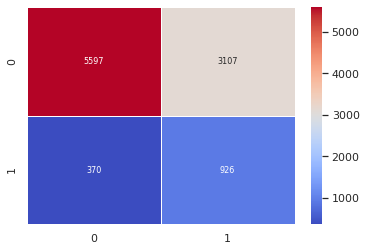

In [26]:
# Confusion matrix
names = ["0", "1"]
cm = confusion_matrix(np.array(trues).flatten(), np.array(preds).flatten())
df_cm = pd.DataFrame(cm, index=names, columns=names)
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8}, cmap='coolwarm', linewidth=0.5, fmt="")
plt.show()

The dataset is heavily unbalanced, but for each class (every row) the majority of the samples are correctly classified

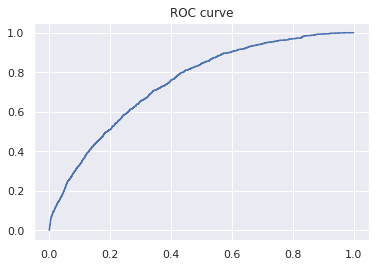

In [40]:
plt.plot(fpr,tpr)
plt.title("ROC curve");

Given that this task is relatively difficult even for a human, the results seem satisfying.

Now we train the second model with 3 classes (we use negative sampling by randomly selecting irrelevant samples and assigning the label 0 to them)

In [135]:
# add negative samples
n_selected = np.sum(l_selected)
l_selected = list(np.array(l_selected)+1)

for i in tqdm(range(n_selected)):
    # sample unrelated query and passage indices
    q_idx = int(np.floor(np.random.uniform(low=0, high=len(df))))
    p_idx = int(np.floor(np.random.uniform(low=0, high=len(df))))
    # tokenize the query
    q = df["query"].iloc[q_idx]
    q = tokenizer(q, max_length=64, truncation=True)
    q_len = len(q['input_ids'])
    # tokenize the passage
    non_selected = np.where(np.array(df["passages"][p_idx]["is_selected"])==0)[0]
    while (q_idx==p_idx or len(non_selected)==0):
        p_idx = int(np.floor(np.random.uniform(low=0, high=len(df))))
        non_selected = np.where(np.array(df["passages"][p_idx]["is_selected"])==0)[0]
    p_idx2 = np.random.choice(non_selected)
    p = df["passages"][p_idx]["passage_text"][p_idx2]
    p = tokenizer(p, max_length=512-q_len+1, padding="max_length", truncation=True)
    p['input_ids'] = p['input_ids'][1:]
    p['attention_mask'] = p['attention_mask'][1:]
    # merge query and passage, add to list
    l_input_ids.append(q['input_ids']+p['input_ids'])
    l_attention_mask.append(q['attention_mask']+p['attention_mask'])
    # add a negative sample
    l_selected.append(0)

  0%|          | 0/88523 [00:00<?, ?it/s]

In [184]:
# train a new model

dataset_df = pd.DataFrame(list(zip(l_input_ids, l_attention_mask, l_selected)), columns=["input_ids", "attention_mask", "labels"])
train_dataset = datasets.Dataset.from_pandas(dataset_df)
eval_dataset = train_dataset.shuffle(seed=42).select(range(10000))
train_dataset = train_dataset.shuffle(seed=42).select(range(10000,len(train_dataset)))
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=16)
eval_dataloader = DataLoader(eval_dataset, batch_size=16)

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)
model.to(device)
optimizer = Adam(model.parameters(), lr=1e-5)
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=3000, num_training_steps=num_training_steps
)
metric = load_metric("accuracy")
num_classes = 3
progress_bar = tqdm(range(num_training_steps))
i=0

for epoch in range(num_epochs):
    print(f"epoch {epoch+1}")
    model.train()
    for batch in train_dataloader:
        #batch = {k: v for k, v in batch.items()}
        batch["input_ids"] = torch.stack(batch["input_ids"], axis=1).to(device)
        batch["attention_mask"] = torch.stack(batch["attention_mask"], axis=1).to(device)
        batch["labels"] = batch["labels"].to(device)
        b_counter = Counter(batch['labels'].detach().cpu().tolist())
        b_weights = torch.tensor([sum(batch['labels'].detach().cpu().tolist()) / b_counter[label] if b_counter[label] > 0 else 0 for label in list(range(num_classes)) ] )
        b_weights = b_weights.to(device)
        outputs = model(**batch)
        logits = outputs.logits
        criterion = torch.nn.CrossEntropyLoss(weight=b_weights)
        loss = criterion(logits, batch['labels'])
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    
        i+=1
        if i%5000==0:
            model.eval()
            preds, trues, logits = [], [], []
            for i, batch in tqdm(enumerate(eval_dataloader), desc="evaluating", total=eval_dataloader.__len__()):
                batch = {k: v for k, v in batch.items()}
                batch["input_ids"] = torch.stack(batch["input_ids"], axis=1).to(device)
                batch["attention_mask"] = torch.stack(batch["attention_mask"], axis=1).to(device)
                batch["labels"] = batch["labels"].to(device)
                with torch.no_grad():
                    outputs = model(**batch)

                b_logits = outputs.logits
                predictions = torch.argmax(b_logits, dim=-1)
                metric.add_batch(predictions=predictions, references=batch["labels"])

                _, tag_seq  = torch.max(b_logits, 1)
                preds.extend(tag_seq.cpu().detach().tolist())
                trues.extend(batch['labels'].cpu().detach().tolist())
                logits.extend(b_logits.cpu().detach().tolist())

            print(metric.compute())

            scores, binary_trues = [],[]
            for j in range(num_classes):
                scores = torch.nn.functional.softmax(torch.tensor(logits), dim=1)[:,j]
                binary_trues = np.array(trues)==j
                fpr, tpr, thresholds = roc_curve(binary_trues, scores)
                print(f"AUC class {j}: ", auc(fpr, tpr))

  0%|          | 0/47170 [00:00<?, ?it/s]

epoch 1


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.7345963172804533}
AUC class 0:  0.9993316619660705
AUC class 1:  0.8533103997233228
AUC class 2:  0.7637849885325299


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6722}
AUC class 0:  0.9991488996865341
AUC class 1:  0.8497334676376743
AUC class 2:  0.7678999400332488


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.6774}
AUC class 0:  0.9992392116048029
AUC class 1:  0.8518151398450429
AUC class 2:  0.7650162433693956


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.7456}
AUC class 0:  0.999329722448002
AUC class 1:  0.8585723340382677
AUC class 2:  0.772284205893508


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.7612}
AUC class 0:  0.9994097897323704
AUC class 1:  0.8555344279959753
AUC class 2:  0.7677374435620541


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.7048}
AUC class 0:  0.999311222429502
AUC class 1:  0.8549661869833536
AUC class 2:  0.7676491208144121


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.7416}
AUC class 0:  0.9993334522904415
AUC class 1:  0.8574070314599298
AUC class 2:  0.7709338674614072


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.7372}
AUC class 0:  0.9994044187592573
AUC class 1:  0.8587914885666358
AUC class 2:  0.7718894336343649


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.7384}
AUC class 0:  0.9994199349038059
AUC class 1:  0.8566038029269172
AUC class 2:  0.7707126018355486


evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

{'accuracy': 0.7292}
AUC class 0:  0.9994299806127763
AUC class 1:  0.8592126968650844
AUC class 2:  0.7734218743526098


The model correctly classifies almost all class 0 documents because they do not feature the same keywords as the query, so they are easy to detect. But we obtain good performance on the other classes too.

In [185]:
model.save_pretrained("model2_save")

### Evaluation of DistilBERT

The models take many hours to train so to make this part immediately runnable we download some saved results:

In [ ]:
!pip install gdown

In [ ]:
!gdown --folder https://drive.google.com/drive/folders/15XH7NaUnRV82haWlK-JBOMR-YOSiZYCM?usp=sharing

In [ ]:
!gdown --folder https://drive.google.com/drive/folders/1Bykb1l3ra-IpBK8K5iIbKWchC7GawRsz?usp=sharing

In [4]:
saves_path = "model1_save/"

In [6]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased", use_fast=True)

We load the dataset (MS MARCO test set for the evaluation)

In [23]:
dataset = load_dataset('ms_marco', 'v1.1')
df = dataset["test"].to_pandas()
del dataset

Reusing dataset ms_marco (/root/.cache/huggingface/datasets/ms_marco/v1.1/1.1.0/b6a62715fa5219aea5275dd3556601004cd63945cb63e36e022f77bb3cbbca84)


  0%|          | 0/3 [00:00<?, ?it/s]

We tokenize the queries and documents

In [ ]:
l_input_ids, l_attention_mask = [],[] # model inputs
df_doc_dict = {} # maps each df index to its passage
doc_number = 0
bm25 = BimExt(index=inverted_index_sortpost, extension='bm25', k=1.5, b=0.75)
bm25.top = 50
for q in df["query"]:
    q_tokenized = tokenizer(q, max_length=64, truncation=True)
    for id,_ in bm25.retrieval(query=q):
        # get passage
        p = bm25.index.documents[id].content
        # add passage to dict
        df_doc_dict[doc_number] = p
        doc_number += 1
        # get model input (token ids and attention mask)
        input_ids, attention_mask = tokenize_passage(q_tokenized,p)
        l_input_ids.append(input_ids)
        l_attention_mask.append(attention_mask)

In [6]:
# The last cell takes a few minutes to run, we saved its results for faster access
l_input_ids = joblib.load(saves_path+"l_input_ids.pkl")
l_attention_mask = joblib.load(saves_path+"l_attention_mask.pkl")

We create the dataloader

In [ ]:
dataset_df = pd.DataFrame(list(zip(l_input_ids, l_attention_mask)), columns=["input_ids", "attention_mask"])
del l_input_ids
del l_attention_mask
test_dataset = datasets.Dataset.from_pandas(dataset_df)
test_dataloader = DataLoader(test_dataset, batch_size=16)

Perform model inference and obtain classification scores

In [340]:
model1 = DistilBertForSequenceClassification.from_pretrained("model2_save", num_labels=3)
model1.to(device)
model1.eval()
logits = []
for i, batch in tqdm(enumerate(test_dataloader), desc="evaluating", total=test_dataloader.__len__()):
    batch["input_ids"] = torch.stack(batch["input_ids"], axis=1).to(device)
    batch["attention_mask"] = torch.stack(batch["attention_mask"], axis=1).to(device)
    with torch.no_grad():
        outputs = model1(**batch)
    logits.extend(outputs.logits.cpu().detach().tolist())
scores = torch.nn.functional.softmax(torch.tensor(logits), dim=1)[:,1]

evaluating:   0%|          | 0/30157 [00:00<?, ?it/s]

In [5]:
# The preceding code takes a few hours to run, we saved its results so they can be used immediately
# saved logits from model inference
logits = joblib.load(saves_path+"logits.pkl")
# saved dict of document ids used for indexation
df_doc_dict = joblib.load(saves_path+"df_doc_dict.pkl")

In [18]:
# Some dictionaries needed to map documents and queries with their IDs
doc_dict = {}
for i in range(1,np.max(list(inverted_index_sortpost.documents.keys()))+1):
    doc_dict[inverted_index_sortpost.documents[i].content] = i
queries = {}
i=0
for query in judgments:
    queries[query] = i
    i+=1

In [37]:
# Placeholder class to yield the retrieval results for model evalutaion
class BERT_model():
    def __init__(self):
        self.top = 10
    def retrieval(self, query):
        # get query id
        query_id = queries[query]
        # get passage scores
        passage_starting_id = query_id*50
        passage_scores = np.array(scores[passage_starting_id:passage_starting_id+50])
        # get the top K
        ind = np.argpartition(passage_scores, -self.top)[-self.top:]
        ind = ind[np.argsort(passage_scores[ind])][::-1] + passage_starting_id
        # convert their indices to IDs
        ids = [doc_dict[df_doc_dict[i]] for i in ind]
        res = [(ids[i], float(scores[ind[i]])) for i in range(len(ids))]
        return(res)

bert1 = BERT_model()

In [342]:
MRR(bert1, {query: rel for pos, (query, rel) in enumerate(judgments.items()) if pos<=100}, at_K=10)

100%|██████████| 101/101 [00:00<00:00, 21187.59it/s]


0.44235030645921736

In [343]:
MAP(bert1, judgments)

  0%|          | 0/9650 [00:00<?, ?it/s]

0.45378162453550946

Now we evaluate the second model (multiclass):

In [ ]:
model2 = DistilBertForSequenceClassification.from_pretrained("model2_save", num_labels=3)
model2.to(device)
model2.eval()
logits = []
for i, batch in tqdm(enumerate(test_dataloader), desc="evaluating", total=test_dataloader.__len__()):
    batch = {k: v for k, v in batch.items()}
    batch["input_ids"] = torch.stack(batch["input_ids"], axis=1).to(device)
    batch["attention_mask"] = torch.stack(batch["attention_mask"], axis=1).to(device)
    with torch.no_grad():
        outputs = model2(**batch)
    logits.extend(outputs.logits.cpu().detach().tolist())

In [ ]:
# saved logits
#logits = joblib.load("drive/MyDrive/Projects/NLP/model2_save/logits.pkl")

We calculate the score of each document with a weighted average of the score of the class 2 (is_selected) and class 1 (relevant). We give more weight to class 2 since its documents are the most relevant.

In [36]:
scores_1 = torch.nn.functional.softmax(torch.tensor(logits), dim=1)[:,1]
scores_2 = torch.nn.functional.softmax(torch.tensor(logits), dim=1)[:,2]
scores = (scores_1+scores_2*2)/3

In [ ]:
bert2 = BERT_model() # this object will retrieve the scores from the 'scores' variable

In [38]:
MRR(bert2, {query: rel for pos, (query, rel) in enumerate(judgments.items()) if pos<=100}, at_K=10)

100%|██████████| 101/101 [00:00<00:00, 6612.52it/s]


0.45594452302373095

In [39]:
MAP(bert2, judgments)

100%|██████████| 9650/9650 [00:01<00:00, 8592.37it/s]


0.5267302297587247

We obtain a significantly better MRR score than the other models, while the MAP is not the best but still satisfactory. We retain the second model (multiclass).

### Next steps: Other deep learning models

Training the MatchPyramid model

In [ ]:
! python ./search-engine/match_pyramid.py

Reusing dataset ms_marco (/root/.cache/huggingface/datasets/ms_marco/v1.1/1.1.0/b6a62715fa5219aea5275dd3556601004cd63945cb63e36e022f77bb3cbbca84)
100% 3/3 [00:00<00:00, 19.24it/s]
.vector_cache/glove.6B.zip: 862MB [02:41, 5.35MB/s]               
100% 399999/400000 [00:10<00:00, 38256.69it/s]
Preprocessing train split
100% 82326/82326 [00:13<00:00, 5905.81it/s]
100% 82326/82326 [00:25<00:00, 3178.71it/s]
Preprocessing test split
100% 9650/9650 [00:01<00:00, 6019.33it/s]
100% 9650/9650 [00:02<00:00, 3333.46it/s]
Preprocessing validation split
100% 10047/10047 [00:02<00:00, 4309.29it/s]
100% 10047/10047 [00:02<00:00, 3385.16it/s]
device cpu
Epoch 0:: 100% 3/3 [00:00<00:00,  4.31it/s]
Epoch 0/100 : Training : (loss 0.9662131567796072) (acc 1.0)
validation:: 100% 3/3 [00:00<00:00, 244.55it/s]
validation : (loss 0.8029371996720632) (acc 0.6666666666666666)
Epoch 1:: 100% 3/3 [00:00<00:00, 88.65it/s]
Epoch 1/100 : Training : (loss 0.9727870523929596) (acc 1.0)
validation:: 100% 3/3 [00:00<00